## 倒立振子
倒立振子問題をsagemathを使って解いてみます。

参考にしたのは、以下の記事です。この記事では、MAXIMAを使用していますが、ここではsagemathで「倒立振子」問題に取り組んでみます。

- <a href="http://cacsd2.sakura.ne.jp/category/%E5%88%B6%E5%BE%A1%E6%8A%80%E8%A1%93%E3%82%BB%E3%83%9F%E3%83%8A%E3%83%BC/%E6%BC%94%E7%BF%92%E6%9B%B8/">７ 非線形システムの線形化</a>




<img src="images/fig.7-1.png" width="250"/>
（「７ 非線形システムの線形化」 から引用）

### 振子のラグランジュ方程式

運動エネルギー$ T = \frac{1}{2}J \dot{\theta}^2 (J=\frac{1}{3} m l ^2)$ 、ポテンシャルエネルギー$V= m g cos\theta$から、ラグランジュ関数$ L = T - V$から以下のラグランジュ方程式となります。

$$
\begin{equation*}
\frac{d}{dt} \left ( \frac{\partial L} { \partial \dot{\theta} } \right )  - \frac{\partial L} { \partial  \theta } = 0
\label{eq:vector_ray} \tag{1}
\end{equation*}
$$



### diff_fで対応
MAXIMAとsagemathの微分関数diffを比べると、sagemathのdiffが関数で微分できません。

これをクリアする方法を検索した結果、以下の記事が見つかりました。
- https://ask.sagemath.org/question/7856/lagranian-mechanics/

要約すると、$\theta(t)$の関数を変数で宣言し、あとで関数を代入することで対応するというものです。


式を関数で微分するために、diff_f関数を用意します。

diff_fには、微分対象の式(eq)、微分したい関数(f)、微分用に関数を置き換えための変数(v)を引数とします。

In [1]:
def diff_f(eq, f, v):
    n_eq = eq.subs(f == v)
    d_eq = diff(n_eq, v).subs(v == f)
    return d_eq

### sageでの解法
最初に変数m, l, g, tと関数用変数th_fun$\theta(t)$, thdot_fuc$\dot{\theta(t)}$を定義し、
関数thを定義します。

次に棒の中心座標（x, y）から運動エネルギーTとポテンシャルエネルギーを定義します。

最後にラグランジュ方程式EulerLagrangeをdiff_fを使って定義すると、以下のようになります。

In [3]:
# https://ask.sagemath.org/question/7856/lagranian-mechanics/
# 変数定義
var('m l g t')
var('th_fun thdot_fun')
# 関数定義
th = function('th')(t)
# 運動エネルギーの定義

x = l*sin(th(t))
y = l*cos(th(t))
J = (1/3)*m*l^2
T = (1/2)*m*(diff(x, t)^2 + diff(y,t)^2)+(1/2)*J*diff(th(t), t)^2
# ポテンシャルエネルギーの定義
V = m*g*l*cos(th(t))
# ラグランジュ方程式の定義
L = T - V
EulerLagrange = diff(diff_f(L, diff(th, t), thdot_fun), t) - diff_f(L, th(t), th_fun) == 0
# 結果を表示
show(EulerLagrange.simplify_full())

-g*l*m*sin(th(t)) + 4/3*l^2*m*diff(th(t), t, t) == 0

$\ddot{\theta}$で式を整理すると以下のようになります。

sinの中に$\theta$が入る非線形方程式になります。

In [60]:
sol = solve(EulerLagrange.simplify_full(), diff(th, t,2))[0]
show(sol)

diff(th(t), t, t) == 3/4*g*sin(th(t))/l

In [68]:
f = matrix([[diff(th, t)], [sol.rhs()]])
show(f)
diff_f(f[1,0], th,th_fun)

[    diff(th(t), t)]
[3/4*g*sin(th(t))/l]

3/4*g*cos(th(t))/l

In [50]:
sol[0].subs(l=0.25, g=9.8)

diff(th(t), t, t) == 29.4000000000000*sin(th(t))

### 数値解析
非線形微分方程式は、数値計算で近似します。

2階常微分方程式を二つの1階微分方程式に分解します。
$$
\left[
    \begin{array} {c}
        \dot{\theta} \\
        \ddot{\theta}
    \end{array}
\right]
    =
\left[   
    \begin{array} {c}
        \dot{\theta} \\
        \frac{3 g} {4 l} sin \theta
    \end{array}
\right]
$$

eulers_method_2x2_plotの使い方
```
eulers_method_2x2_plot(f, g, t0, x0, y0, h, t1)
2階常微分方程式を( x=z, y=z′ として)二つの1階微分方程式に分解してからオイラー法を適用します。
x' = f(t, x, y), y' = g(t, x, y)とし、t0, x0, y0は初期値、hは時間刻み、t1計算終了時刻
```

ここで、x=$\theta$、y=$\dot{\theta}$とすると、関数f、gは以下のようになります。

どうも発散しているように思われます。刻みが0.1秒では難しいのかも知れませんが、0.05にすると計算が終了しません。

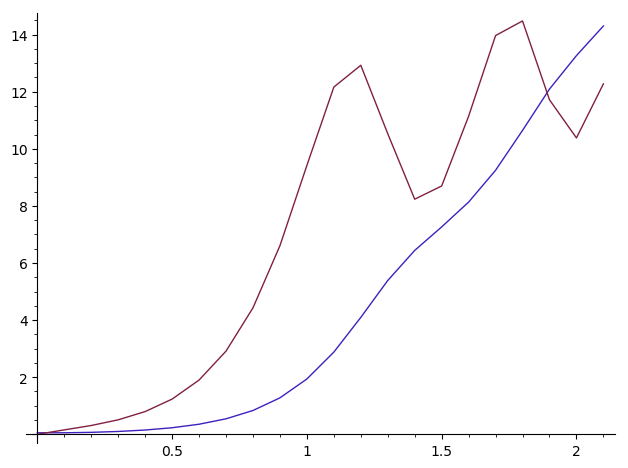

In [5]:
f = lambda z: z[2]
g = lambda z: 29.4*sin(z[1])
P = eulers_method_2x2_plot(f,g, 0.0, (3/180)*pi, 0.0, 0.1, 2.0)
(P[0]+P[1]).show()

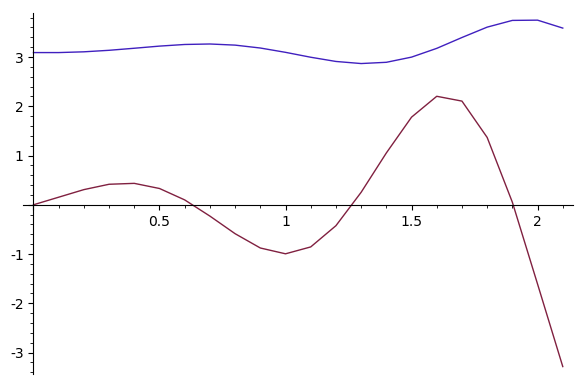

In [6]:
P = eulers_method_2x2_plot(f,g, 0.0, (177/180)*pi, 0.0, 0.1, 2.0)
(P[0]+P[1]).show()

### ルンゲクッタで計算
そこで、連立一次常微分方程式を解く関数desolve_system_rk4を使って計算することにしました。

```
desolve_system_rk4(des, vars, ics=None, ivar=None, end_points=None, step=0.1)
des: 連立一次常微分方程式の右辺
vars: 変数（例ではth, th_dot）
ics: t, th, th_dotの初期値
```

こんどは、きれいな振動が表示されました。オイラー法でも1.5秒程度までは計算できていますが、それ以降は発散していることがわかります。

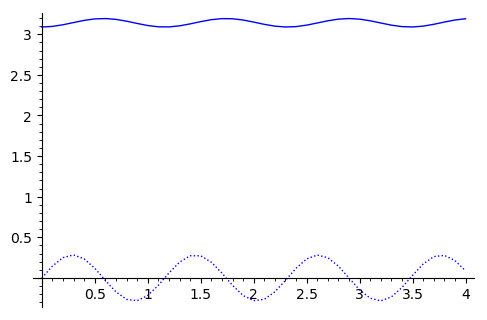

In [7]:
(th,th_dot,t) = var('th th_dot t')
P=desolve_system_rk4([th_dot, 29.4*sin(th)],[th, th_dot],ics=[0,(177/180)*pi,0],ivar=t,end_points=4)
plt_f = list_plot([(i,j) for i, j, k in P], plotjoined=True, linestyle ='-')
plt_g = list_plot([(i,k) for i, j, k in P], plotjoined=True, linestyle =':')
(plt_f+plt_g).show(figsize=5)

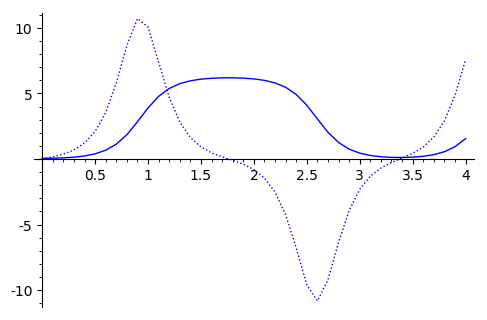

In [8]:
(th,th_dot,t) = var('th th_dot t')
P=desolve_system_rk4([th_dot, 29.4*sin(th)],[th, th_dot],ics=[0,(3/180)*pi,0],ivar=t,end_points=4)
plt_f = list_plot([(i,j) for i, j, k in P], plotjoined=True, linestyle ='-')
plt_g = list_plot([(i,k) for i, j, k in P], plotjoined=True, linestyle =':')
(plt_f+plt_g).show(figsize=5)

## 倒立振子台車


In [47]:
# 変数定義
var('m M l g t')
var('thF dthF ddthF rF drF ddrF')
# 関数定義
th = function('th')(t)
r = function('r')(t)
F = function('F')(t)
# 台車の運動エネルギー
Tcart = 1/2*M*diff(r,t)^2
# 振子の運動エネルギー
x = r(t) + l*sin(th(t))
y = l*cos(th(t))
J = (1/3)*m*l^2
Tpen = (1/2)*m*(diff(x, t)^2 + diff(y,t)^2)+(1/2)*J*diff(th(t), t)^2
# ポテンシャルエネルギーの定義
Upen = m*g*l*cos(th(t))
# ラグランジュ関数
L = Tcart + Tpen - Upen
# ラグランジュ方程式
LEr = diff(diff_f(L, diff(r, t), drF), t) - diff_f(L, r(t), rF) == F
LEth = diff(diff_f(L, diff(th, t), dthF), t) - diff_f(L, th(t), thF) == 0
# 結果を表示
show(LEr.simplify_full())
show(LEth.simplify_full())

-l*m*sin(th(t))*diff(th(t), t)^2 + l*m*cos(th(t))*diff(th(t), t, t) + (M + m)*diff(r(t), t, t) == F(t)

-g*l*m*sin(th(t)) + l*m*cos(th(t))*diff(r(t), t, t) + 4/3*l^2*m*diff(th(t), t, t) == 0

In [98]:
# th(t) = thF, dth(t) = dthF, ddth(t) = ddthF, r(t) = rF, dr(t) = drF, ddr(t) =ddrFに置換して解く
subDict = {th(t): thF, diff(th, t):dthF, diff(th,t,2):ddthF, r(t): rF, diff(r,t): drF, diff(r, t, 2): ddrF}
eq = [LEr.simplify_full().subs(subDict), LEth.simplify_full().subs(subDict)]
#show(eq)
sol = solve(eq, [ddrF, ddthF])[0]
show(sol[0])
show(sol[1])

ddrF == -((4*dthF^2*l*m - 3*g*m*cos(thF))*sin(thF) + 4*F(t))/(3*m*cos(thF)^2 - 4*M - 4*m)

ddthF == 3*(F(t)*cos(thF) + (dthF^2*l*m*cos(thF) - M*g - g*m)*sin(thF))/(3*l*m*cos(thF)^2 - 4*M*l - 4*l*m)

In [116]:
f1 = drF
f2 = dthF
f3 = sol[0].rhs()
f4 = sol[1].rhs()
ff = [f1, f2, f3, f4]
vv = [rF, thF, drF, dthF]
# 平衡状態 + θの値
subeq = [rF == 0, drF == 0, dthF == 0, F == 0, thF == 0]
# 線形状態方程式
A = matrix([[ diff(f, v).subs(subeq) for v in vv] for f in ff])
show(A)


[                          0                           0                           1                           0]
[                          0                           0                           0                           1]
[                          0            -3*g*m/(4*M + m)                           0                           0]
[                          0 3*(M*g + g*m)/(4*M*l + l*m)                           0                           0]

## リッカチの方程式

以下のサイトを参考にリッカチの方程式を使った最適化の方法をみてみましょう。
- <a href="http://mech.u-fukui.ac.jp/~Kawa-Lab/education/robust/pdf/chap5f.pdf">最適レギュレータ</a>

リッカチの方程式は、正則な解Xが存在する時、以下の関係が成り立ちます。

$$
\begin{equation*}
A^TX + XA - XBR^{-1}B^TX + Q = 0
\label{eq:riccati_equation} \tag{2}
\end{equation*}
$$

### 最適化問題
状態方程式が以下のように与えられた場合、

$$
\begin{equation*}
\dot{x} = A x + B u
\label{eq:state_equation} \tag{3}
\end{equation*}
$$

評価関数Jを最小にする操作量uを求めます。ここでQは準正則、Rは対称行列とします。

$$
\begin{equation*}
J = \int_0^{\infty} (x^T Q x + u^T R u) dt
\label{eq:cost_equation} \tag{4}
\end{equation*}
$$

以下の行列の微分を考えます。

$$
\begin{equation*}
\frac{d}{dt}(x(t)^T X x(t)) = \dot{x}^T X x + x^T X \dot{x}
\tag{5}
\end{equation*}
$$

このXに$\eqref{eq:state_equation}$を代入すると、
$$
\begin{equation*}
\frac{d}{dt}(x(t)^T X x(t)) = (A x + B u)^T X x + x^T X  (A x + B u)
\tag{6}
\end{equation*}
$$

となり、転置行列の$(A B)^T = B^TA^T$を使って、これを展開すると以下のようになります。
$$
\begin{eqnarray}
\frac{d}{dt}(x(t)^T X x(t)) & = & x^TA^T X x + u^TB^T X x +  x^T X A x + x^T X B u \\
& = & x^T(A^T X x + X A x) +  u^TB^T X x  + x^T X B u
\tag{7}
\end{eqnarray}
$$

ここにリッカチの方程式から$A^T + X A = -Q + X B R^{-1} B T X$を代入し、$u^T R u - u^T Ru$を足すと以下のようになります。
$$
\begin{equation*}
\frac{d}{dt}(x(t)^T X x(t)) = -(x^T Q + u^T R u) + x^T X B R^{-1} B^T X x + u^T R u + u^T B^T X x + x^T X B u
\tag{8}
\end{equation*}
$$

ここで、Rが対称行列なので、$(R^{-1})^T = (R^T)^{-1} = R^{-1}$を使って行列順序を入れ替えていくと以下のようになります。
$$
\begin{eqnarray}
(u + R^{-1} B^T X x)^T R (u + R^{-1} B^T X x) & = & (u^TR + (R^{-1} B^T X x)^TR)(u + R^{-1} B^T X x) \\
& = & u^T R u +(R^{-1}B^TX x)^T R u + u^T R R^{-1} B^T X x+ (R^{-1} B^T X x)^T R R^{-1} B^T X x \\
& = & u^T R u +(R^{-1}B^TX x)^T R u + u^T B^T X x + (R^{-1} B^T X x)^T B^T X x \\
& = & u^T R u + (X x)^T(R^{-1}B^T)^T Ru + u^T B^T X x + (X x)^T (R^{-1}B^T)^T B^T X x \\
& = & u^T R u + x^T X^T B R^{-1} R u +  u^T B^T X x + x^T X^T B R^{-1} B^T X x \\
& = & u^T R u + x^T X^T B u +  u^T B^T X x + x^T X^T B R^{-1} B^T X x 
\tag{9}
\end{eqnarray}
$$

従って$\frac{d}{dt}(x(t)^T X x(t))$は、以下のようになります。
$$
\begin{equation*}
\frac{d}{dt}(x(t)^T X x(t)) = -(x^T Q + u^T R u) + (u + R^{-1} B^T X x)^T R (u + R^{-1} B^T X x)
\tag{10}
\end{equation*}
$$

評価関数Jは、以下のようになります。
$$
\begin{equation*}
J = \left [ -x^T(t) X x(t) \right ]_0^{\infty} + \int_0^{\infty} (u + R^{-1} B^T X x)^T R (u + R^{-1} B^T X x) dt
\tag{10}
\end{equation*}
$$

この式から、評価関数Jを最小にする操作量uは、以下のようになります。

$$
\begin{equation*}
u =  -R^{-1} B^T X x
\tag{11}
\end{equation*}
$$

ゲインの定義($u = -K x$)から、最適操作量uのゲインKは以下のようになります。
$$
\begin{equation*}
K = R^{-1} B^T X
\tag{12}
\end{equation*}
$$